# Physics Informed NODEs for residential temperature predictions

## Import the required libraries

In [1]:
import time

import diffrax
import equinox as eqx 
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax 
from typing import Callable, Union, Literal, Optional, List
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from jax.tree_util import tree_leaves
import warnings
warnings.filterwarnings("ignore")

# Global variables
house_idx = 79
num_of_zones = 12

## Helper functions to create a masked MLP

In [2]:
def CreateConnectivity(num_zones=None, num_hidden=None):
    """
    Generate sparse connection indices for a masked neural network.

    Creates three distinct sets of connections to define structured sparsity.

    Args:
        num_zones (int): Number of thermal zones.
        num_hidden (int): Number of hidden units per zone.

    Returns:
        Tuple[jax.Array, jax.Array, jax.Array]: Three 2xN arrays containing (row_indices, column_indices)
        for the three different sets of connections.
    """
    # Create connections1
    row_part1 = jnp.repeat(jnp.arange(num_zones), num_hidden)[None, :]
    row_part2 = jnp.arange(num_zones, num_zones*2 + 2)[None, :]
    row = jnp.concatenate([row_part1, row_part2], axis=1).astype(jnp.int32)
    
    col_part1 = jnp.tile(jnp.arange(num_hidden), (1, num_zones))
    col_part2 = jnp.arange(num_hidden, num_hidden + num_zones + 2)[None, :]
    col = jnp.concatenate([col_part1, col_part2], axis=1).astype(jnp.int32)
    
    connections1 = jnp.concatenate([row, col], axis=0)

    # Create connections2
    row_part1 = jnp.repeat(jnp.arange(num_hidden), num_zones*num_hidden)[None, :]
    row_part2 = jnp.repeat(jnp.arange(num_hidden, num_hidden + num_zones), num_hidden)[None, :]
    row_part3 = jnp.repeat(jnp.arange(num_hidden + num_zones, num_hidden + num_zones + 2), 
                          num_hidden*num_zones)[None, :]
    row = jnp.concatenate([row_part1, row_part2, row_part3], axis=1).astype(jnp.int32)
    
    col = jnp.tile(jnp.arange(num_zones*num_hidden)[None, :], (1, num_hidden + 3))
    connections2 = jnp.concatenate([row, col], axis=0).astype(jnp.int32)

    # Create connections3
    row_conn3 = jnp.arange(num_zones*num_hidden)[None, :]
    col_conn3 = jnp.repeat(jnp.arange(num_zones), num_hidden)[None, :]
    connections3 = jnp.concatenate([row_conn3, col_conn3], axis=0).astype(jnp.int32)

    return connections1, connections2, connections3

def create_mask_from_connections(connections):
    """
    Create a binary mask matrix from a set of connection indices.

    This function constructs a mask used to zero out non-connected weights in a
    neural network layer, based on the specified (input, output) index pairs.

    Args:
        connections (jax.Array): A 2xN array where the first row contains source indices (rows),
                                 and the second row contains target indices (columns).

    Returns:
        jax.Array: A binary 2D mask of shape (out_features, in_features), where 1 indicates
                   a valid connection and 0 indicates no connection.
    """
    in_features = jnp.max(connections[0]) + 1  # Input layer size
    out_features = jnp.max(connections[1]) + 1  # Output layer size

    # Initialize a mask of zeros
    mask = jnp.zeros((out_features, in_features))

    # Set 1s where connections exist
    row_idx, col_idx = connections  # Extract row and column indices
    mask = mask.at[col_idx, row_idx].set(1)

    return mask


class MaskedMLP(eqx.Module):
    """
    A masked multilayer perceptron (MLP) with structured sparsity.

    Each linear layer in the network applies a binary mask to its weights to enforce
    a predefined sparsity pattern. Built using Equinox and compatible with JAX transformations.

    Attributes:
        layers (tuple): Sequence of linear layers.
        masks (tuple): Binary masks applied to weights of each layer.
        activation (Callable): Activation function for hidden layers.
        final_activation (Callable): Activation function for the output layer.
        use_bias (bool): Whether to include bias terms in hidden layers.
        use_final_bias (bool): Whether to include a bias term in the final layer.
        in_size (int or 'scalar'): Dimensionality of the input.
        out_size (int or 'scalar'): Dimensionality of the output.
        hidden_sizes (List[int]): Sizes of hidden layers.
        depth (int): Number of hidden layers.
    """
    layers: tuple
    masks: tuple = eqx.field(static=True)
    activation: Callable
    final_activation: Callable
    use_bias: bool = eqx.field(static=True)
    use_final_bias: bool = eqx.field(static=True)
    in_size: Union[int, Literal["scalar"]] = eqx.field(static=True)
    out_size: Union[int, Literal["scalar"]] = eqx.field(static=True)
    hidden_sizes: List[int] = eqx.field(static=True)
    depth: int = eqx.field(static=True)

    def __init__(
        self,
        in_size: Union[int, Literal["scalar"]],
        out_size: Union[int, Literal["scalar"]],
        hidden_sizes: List[int],
        masks: list,
        activation: Callable = jax.nn.soft_sign,
        final_activation: Callable = lambda x: x,
        use_bias: bool = True,
        use_final_bias: bool = True,
        *,
        key: jax.random.PRNGKey,
        **kwargs,
    ):
        super().__init__(**kwargs)
        depth = len(hidden_sizes)
        keys = jax.random.split(key, depth + 1)
        layers = []
        
        # Input layer
        layers.append(eqx.nn.Linear(in_size, hidden_sizes[0], use_bias, key=keys[0]))
        
        # Hidden layers
        for i in range(depth - 1):
            layers.append(eqx.nn.Linear(hidden_sizes[i], hidden_sizes[i + 1], use_bias, key=keys[i + 1]))
        
        # Output layer
        layers.append(eqx.nn.Linear(hidden_sizes[-1], out_size, use_final_bias, key=keys[-1]))
        
        self.layers = tuple(layers)
        self.masks = tuple(jnp.array(m) for m in masks)
        self.in_size = in_size
        self.out_size = out_size
        self.hidden_sizes = hidden_sizes
        self.depth = depth
        self.activation = activation
        self.final_activation = final_activation
        self.use_bias = use_bias
        self.use_final_bias = use_final_bias
    
    @jax.named_scope("eqx.nn.MaskedMLP")
    def __call__(self, x: jax.Array, *, key: Optional[jax.random.PRNGKey] = None) -> jax.Array:
        for layer, mask in zip(self.layers[:-1], self.masks[:-1]):
            weight_masked = layer.weight * mask
            x = (weight_masked @ x) + (layer.bias if self.use_bias else 0)
            x = self.activation(x)
        
        weight_masked = self.layers[-1].weight * self.masks[-1]
        x = (weight_masked @ x) + (self.layers[-1].bias if self.use_final_bias else 0)
        x = self.final_activation(x)
        
        return x

Masked MLPs of the `MaskedMLP` class have a sparse stucture that blocks the interference of adjacent zone heating $Q_j$ on the temperature rate of change of another zone $\frac{T_i}{dt}$.


<div style="text-align: center;">
  <img src="NN_Archi_revised_190mm_1000DPI_test.png" width="50%" height="50%">
</div>

## NODE model structure


In [3]:
class Func(eqx.Module):
    """
    Function module for use in Neural ODEs, either using a MaskedMLP or a standard MLP.

    This class wraps an MLP (either masked or unmasked) and evaluates it on concatenated
    inputs, typically the system state and interpolated exogenous inputs.

    Attributes:
        mmlp (Callable): A MaskedMLP or standard Equinox MLP used for function approximation.
    """
    mmlp: None

    def __init__(
        self,
        in_size: Union[int, Literal["scalar"]],
        out_size: Union[int, Literal["scalar"]],
        hidden_sizes: List[int],
        masks: list,
        mmlp_flag: bool = True,
        *,
        key: jax.random.PRNGKey,
        **kwargs,
        ):
        
        super().__init__(**kwargs)

        if mmlp_flag:
            self.mmlp = MaskedMLP(
            in_size = in_size, 
            out_size = out_size, 
            hidden_sizes = hidden_sizes, 
            masks = masks, 
            key = key
            )
        else:
            self.mmlp = eqx.nn.MLP(
            in_size=in_size,
            out_size=out_size,
            width_size=24,
            depth=2,
            activation=jnn.soft_sign,
            key=key,
            )
            
    def __call__(self, t, y, args):
        
        ts, us = args  
        _ts, _us = diffrax.rectilinear_interpolation(ts, us)

        interpolator = diffrax.LinearInterpolation(_ts, _us)

        return self.mmlp(jnp.concatenate([y, jnp.atleast_1d(interpolator.evaluate(t))]))
    
class NeuralODE(eqx.Module):
    """
    Neural Ordinary Differential Equation module.

    Wraps the differential equation solver to model system dynamics
    using a neural network (either masked or unmasked) as the derivative function.

    Attributes:
        func (Func): Callable differential function approximator.
    """
    func: Func

    def __init__(self, in_size, out_size, hidden_sizes, masks, mmlp_flag, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(in_size, out_size, hidden_sizes, masks, mmlp_flag, key=key)

    def __call__(self, ts, y0, args):

        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            args=(ts, args),  
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

## Helper functions


In [4]:
def split_sequence_data(data, timestamps, split_ratio):
    timestamps_series = pd.to_datetime(timestamps)
    sort_idx = np.argsort(timestamps_series.values)
    timestamps_sorted = timestamps_series.values[sort_idx]
    data_sorted = data[sort_idx]

    dates = pd.to_datetime(timestamps_sorted).normalize().to_numpy()
    unique_dates, start_indices, counts = np.unique(dates, return_index=True, return_counts=True)

    total_days = len(unique_dates) - 1
    train_days = int(np.ceil(split_ratio[0] / 100 * total_days))
    val_days = int(np.ceil(split_ratio[1] / 100 * total_days))
    test_days = total_days - train_days - val_days


    def get_slice(start_day, num_days):
        if num_days <= 0 or start_day >= len(start_indices):
            return slice(0, 0)
        start_idx = start_indices[start_day]
        end_day = start_day + num_days
        end_idx = start_indices[end_day] if end_day < len(start_indices) else len(data_sorted)
        return slice(start_idx, end_idx)

    train_slice = get_slice(0, train_days)
    val_slice = get_slice(train_days, val_days)
    test_slice = get_slice(train_days + val_days, test_days)

    return (
        data_sorted[train_slice], data_sorted[val_slice], data_sorted[test_slice],
        timestamps_sorted[train_slice], timestamps_sorted[val_slice], timestamps_sorted[test_slice]
    )

def create_sliding_windows(data, timestamps, window_size=24, stride=1, jax_flag=True):
    # Ensure timestamps are NumPy datetime64 arrays
    timestamps = np.asarray(timestamps)
    if not np.issubdtype(timestamps.dtype, np.datetime64):
        timestamps = pd.to_datetime(timestamps).to_numpy()

    timestamps_hours = timestamps.astype('datetime64[h]')
    min_time = timestamps_hours[0]
    max_time = timestamps_hours[-1]

    windowed_data = []
    windowed_timestamps = []

    delta = np.timedelta64(window_size, 'h')
    stride_delta = np.timedelta64(stride, 'h')
    current_start = min_time

    while current_start + delta <= max_time:
        current_end = current_start + delta
        mask = (timestamps_hours >= current_start) & (timestamps_hours < current_end)
        window = data[mask]
        if len(window) >= window_size:
            if jax_flag:
                windowed_data.append(jnp.array(window))
            else:
                windowed_data.append(np.array(window))
            windowed_timestamps.append(timestamps[mask])
        current_start += stride_delta

    return windowed_data, windowed_timestamps

def build_presence_masks(list1, list2):
    return [
        jnp.isin(arr1, arr2, assume_unique=True).astype(jnp.int32)
        for arr1, arr2 in zip(list1, list2)
    ]

def dataloader(arrays, batch_size, *, key):

    dataset_size = arrays[0].shape[0]

    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size


In [ ]:
def get_data(time_horizon = 24, split_ratio = [75, 12.5], stride = 1, num_zones = num_of_zones, first_zone_index = 1):

    """
    Loads, processes, and prepares the multivariate time-series data.

    This function performs the following tasks:
    1. Loads temperature and energy consumption (Wh) data for a set of zones from a CSV file.
    2. Cleans, regularizes, and interpolates time series data across zones.
    3. Integrates external weather data (temperature and GHI).
    4. Constructs input/output arrays and presence masks for model training.
    5. Scales the features and splits the dataset into training, validation, and test sets.
    6. Applies a sliding window approach to create sequences of specified `time_horizon`.

    Parameters
    ----------
    time_horizon : int, optional
        The length of the time window (in hours) for each input sequence. Default is 24.
    split_ratio : list of float, optional
        A list containing the train and validation split ratios as percentages.
        The test ratio is inferred as the remaining percentage. Default is [75, 12.5].
    stride : int, optional
        The stride (in hours) used in the sliding window. Default is 1.
    num_zones : int
        Number of thermal zones to include in the dataset.
    first_zone_index : int, optional
        Index of the first thermal zone to consider. Default is 1.

    Returns
    -------
    tuple
        A tuple containing:
        
        - `(t_train_float, t_val_float, t_test_float)`: Tuple of JAX arrays of timestamps (in hours) relative to start.
        - `(t_train, t_val, t_test)`: Tuple of original datetime timestamps corresponding to each sequence.
        - `(x_train, x_val, x_test)`: Tuple of model target sequences (e.g., temperatures).
        - `(u_train, u_val, u_test)`: Tuple of input sequences (e.g., weather, energy consumption).
        - `(x_scaler, u_scaler)`: Tuple of fitted `MinMaxScaler` objects for inverse transformation.
        - `(presence_mask_train, presence_mask_val, presence_mask_test)`: Tuple of presence masks indicating data availability.

    """

    # 1. Data Loading
    filenames = []
    filenames.append(fr"THER_000{house_idx} (2018-02-01_2018-02-09).csv")
    names = None
    skiprows = range(1)
    header = None

    dfs = [pd.read_csv(filename, header=header, skiprows=skiprows, index_col=None,
                       names=names, converters=None, dtype=None) for filename in filenames]

    for df in dfs:
        df.columns = ["deviceKey", "value", "variable", "time"]
        df['time'] = pd.to_datetime(df['time'])

        unique_value = df.variable.unique()
        df_value_dict = {elem: df[df.variable == elem].reset_index(drop=True) for elem in unique_value}

        df_device_TEMP_dict = {elem: df_value_dict['TEMP'][df_value_dict['TEMP'].deviceKey == elem] for elem in df.deviceKey.unique()}
        df_device_Wh_dict = {elem: df_value_dict['Wh'][df_value_dict['Wh'].deviceKey == elem] for elem in df.deviceKey.unique()}

        df_device_TEMP_dict = dict(sorted(df_device_TEMP_dict.items()))
        df_device_Wh_dict = dict(sorted(df_device_Wh_dict.items()))

    start_time = pd.Timestamp('2018-02-01')
    end_time = pd.Timestamp('2018-02-09')

    all_df_data = []

    for zone in range(first_zone_index, first_zone_index + num_zones):
        zone_name = f'T0{zone}' if zone < 10 else f'T{zone}'

        df_device_Wh_dict[zone_name] = df_device_Wh_dict[zone_name].drop_duplicates()
        df_device_TEMP_dict[zone_name] = df_device_TEMP_dict[zone_name].drop_duplicates()

        filtered_Wh_df = df_device_Wh_dict[zone_name][
            (df_device_Wh_dict[zone_name]['time'] >= start_time) &
            (df_device_Wh_dict[zone_name]['time'] <= end_time)
        ].copy()

        filtered_TEMP_df = df_device_TEMP_dict[zone_name][
            (df_device_TEMP_dict[zone_name]['time'] >= start_time) &
            (df_device_TEMP_dict[zone_name]['time'] <= end_time)
        ].copy()

        df_Wh_pivot = filtered_Wh_df.pivot(index='time', columns='variable', values='value')
        df_TEMP_pivot = filtered_TEMP_df.pivot(index='time', columns='variable', values='value')

        merged_df = df_Wh_pivot.join([df_TEMP_pivot], how='outer')

    # 2. Data Resampling and Regularization

        start, end = start_time, end_time
        regular_index = pd.date_range(start=start.floor("min"), end=end.ceil("min"), freq="1min")
        df_regular = pd.DataFrame(index=regular_index, columns=["Wh", "TEMP"])
        rounded_times = merged_df.index.round("1min")
        for col in ["Wh", "TEMP"]:
            for i, val in enumerate(merged_df[col]):
                if not pd.isna(val):
                    t = rounded_times[i]
                    df_regular.loc[t, col] = val

        all_df_data.append(df_regular)

    union_index = all_df_data[0].index
    for df in all_df_data[1:]:
        union_index = union_index.union(df.index)

    all_df_data = [df.reindex(union_index) for df in all_df_data]

    for df in all_df_data:
        if 'TEMP' in df.columns:
            first_valid_TEMP = df['TEMP'].dropna().iloc[0] if df['TEMP'].notna().any() else np.nan
            df.iloc[0, df.columns.get_loc('TEMP')] = first_valid_TEMP

        if 'Wh' in df.columns:
            first_valid_Wh = df['Wh'].dropna().iloc[0] if df['Wh'].notna().any() else np.nan
            df.iloc[0, df.columns.get_loc('Wh')] = first_valid_Wh

    elapsed_time_arrays = []
    for df in all_df_data:
        temp_series = df['TEMP']
        timestamps = temp_series.index
        first_time = timestamps[0]
        elapsed_array = np.zeros(len(temp_series), dtype=float)
        for i, ts in enumerate(timestamps):
            if not np.isnan(temp_series.iloc[i]):
                elapsed_array[i] = (ts - first_time) / np.timedelta64(1, 'h')
            else:
                elapsed_array[i] = 0.0
        elapsed_time_arrays.append(elapsed_array)

    elapsed_time_arrays = pd.DataFrame(elapsed_time_arrays).T 
    elapsed_time_arrays.index = all_df_data[0].index

    for merged_df in all_df_data:

        merged_df['TEMP'] = merged_df['TEMP'].interpolate(method='time')
        merged_df['Wh'] = merged_df['Wh'].fillna(method='ffill')
        merged_df.index.name = 'time'

    df_data = all_df_data[0].join(all_df_data[1], how='outer', on='time', lsuffix='_01', rsuffix='_02')

    for i in range(3, len(all_df_data)+1):
        if i < 10:
            df_data = df_data.join(all_df_data[i-1], how='outer', on='time',lsuffix= f'_0{i-1}', rsuffix=f'_0{i}')
        else:
            df_data = df_data.join(all_df_data[i-1], how='outer', on='time',lsuffix= f'_{i-1}', rsuffix=f'_{i}')

    temp_list = []
    for i in range(1,  len(all_df_data)+1):
        if i < 10:
            temp_list.append(f'T0{i}_Wh')
            temp_list.append(f'T0{i}_TEMP')
        else:
            temp_list.append(f'T{i}_Wh')
            temp_list.append(f'T{i}_TEMP')

    df_data.columns = temp_list

    df_data = df_data.bfill()

    temp_names = []
    for i in range(1, len(all_df_data)+1):
        if i < 10:
            temp_names.append(f'T0{i}_TEMP')
        else:
            temp_names.append(f'T{i}_TEMP')

    # 3. Weather Data Integration

    datetime_index = pd.date_range(start="2017-05-01", periods=24*365, freq="H")

    T_ext = pd.read_csv(r'Weather_Shawinigan_0517_0418.csv')['Temp (°C)']
    T_ext.index = datetime_index
    T_ext.columns = ['T_ext']

    GHI = pd.read_csv(r'46.45_-72.66_May17-April18.csv')[['Source','Location ID','City','State','Country','Time Zone']][2:]
    GHI.columns = ['year','month','day','hour','minute','GHI']

    GHI['datetime'] = pd.to_datetime(GHI[['year','month','day','hour','minute']])
    
    GHI = GHI.set_index('datetime')[['GHI']].astype(float)
    GHI = GHI.resample('H').interpolate(method='linear')

    GHI.index = datetime_index

    T_ext = T_ext.loc[(T_ext.index >= start_time) & (T_ext.index <= end_time)].copy()
    GHI = GHI.loc[(GHI.index >= start_time) & (GHI.index <= end_time)].copy()

    df_data = pd.concat([df_data, GHI, T_ext], axis=1)

    wh_columns = [col for col in df_data.columns if col.endswith("_Wh")]

    df_shifted = df_data.copy()
    df_shifted[wh_columns] = df_shifted[wh_columns].shift(-60)

    last_valid_values = df_data[wh_columns].iloc[-1]
    df_shifted.iloc[-60:, df_shifted.columns.get_indexer(wh_columns)] = last_valid_values.values

    df_data = df_shifted

    # 4. Input/Target Vectors Creation

    u_array = df_data.loc[:, ~df_data.columns.isin(temp_names)].copy()
    x_array = df_data[temp_names].copy()

    u_array = u_array.resample('1min').interpolate(method='ffill')
    x_array = x_array.resample('1min').interpolate(method='linear')

    df_data = pd.concat([x_array, u_array], axis=1)

    u_array = df_data.loc[:, ~df_data.columns.isin(temp_names)].copy().values
    x_array = df_data[temp_names].values

    timestamps = df_data.index.to_numpy()

    # 5. Train/Validation/Test Splitting

    (x_train, x_val, x_test, _t_train, _t_val, _t_test) = split_sequence_data(x_array, timestamps, split_ratio)

    (u_train, u_val, u_test, _, _, _) = split_sequence_data(u_array, timestamps, split_ratio)

    (presence_mask_train, presence_mask_val, presence_mask_test, _, _, _)= split_sequence_data(elapsed_time_arrays.values, timestamps, split_ratio)

    u_scaler = MinMaxScaler()
    u_scaler.fit(u_train)

    u_train = u_scaler.transform(u_train)
    u_val = u_scaler.transform(u_val)
    u_test = u_scaler.transform(u_test)
    
    x_scaler = MinMaxScaler()
    x_scaler.fit(x_train)

    x_train = x_scaler.transform(x_train)
    x_val = x_scaler.transform(x_val)
    x_test = x_scaler.transform(x_test)

    # 6. Sliding Window Creation
    
    x_train, t_train = create_sliding_windows(x_train, _t_train, time_horizon, stride)
    x_val, t_val = create_sliding_windows(x_val, _t_val, time_horizon, stride)
    x_test, t_test = create_sliding_windows(x_test, _t_test, time_horizon, stride)

    presence_mask_train, _ = create_sliding_windows(presence_mask_train, _t_train, time_horizon, stride, jax_flag=False)
    presence_mask_val, _ = create_sliding_windows(presence_mask_val, _t_val, time_horizon, stride, jax_flag=False)
    presence_mask_test, _ = create_sliding_windows(presence_mask_test, _t_test, time_horizon, stride, jax_flag=False)
    
    initial_time = timestamps[0]

    def modify_presence_mask(presence_mask_list, time_horizon):
        result = []

        for array in presence_mask_list:
            array = np.copy(array)  # avoid mutating input
            for col in range(array.shape[1]):
                column = array[:, col]
                non_zero_indices = np.flatnonzero(column)

                first_idx = non_zero_indices[0]

                column[0] = first_idx/60

                for i in range(len(non_zero_indices) - 1):
                    curr_idx = non_zero_indices[i]
                    next_idx = non_zero_indices[i + 1]

                    column[curr_idx] = (next_idx - curr_idx)/60


                if len(non_zero_indices) > 0:


                    last_idx = non_zero_indices[-1]

                    column[last_idx] = time_horizon - (last_idx/60)


                array[:, col] = column

            result.append(array)

        return result
    
    presence_mask_train = modify_presence_mask(presence_mask_train, time_horizon)
    presence_mask_val = modify_presence_mask(presence_mask_val, time_horizon)
    presence_mask_test = modify_presence_mask(presence_mask_test, time_horizon)


    t_train_float = [
    jnp.asarray((ts_batch - initial_time) / np.timedelta64(1, 'h'), dtype=jnp.float32)
    for ts_batch in t_train
]


    t_val_float = [
    jnp.asarray((ts_batch - initial_time) / np.timedelta64(1, 'h'), dtype=jnp.float32)
    for ts_batch in t_val
]


    t_test_float = [
    jnp.asarray((ts_batch - initial_time) / np.timedelta64(1, 'h'), dtype=jnp.float32)
    for ts_batch in t_test
]

    u_train, _ = create_sliding_windows(u_train, _t_train, time_horizon, stride)
    u_val, _ = create_sliding_windows(u_val, _t_val, time_horizon, stride)
    u_test, _ = create_sliding_windows(u_test, _t_test, time_horizon, stride)

    
    return (t_train_float, t_val_float, t_test_float), (t_train, t_val, t_test),(x_train, x_val, x_test), (u_train, u_val, u_test), (x_scaler, u_scaler), (presence_mask_train, presence_mask_val, presence_mask_test)

## Model Inference and Reconstruction

In [6]:
key = jr.PRNGKey(5678)
data_key, model_key, loader_key = jr.split(key, 3)

__ts, _, __X, __U, __scalers, __presence = get_data()

ys, _, _ = __X
us, _, _ = __U

class Func(eqx.Module):
    """
    Function module for use in Neural ODEs, either using a MaskedMLP or a standard MLP.

    This class wraps an MLP (either masked or unmasked) and evaluates it on concatenated
    inputs, typically the system state and interpolated exogenous inputs.

    Attributes:
        mmlp (Callable): A MaskedMLP or standard Equinox MLP used for function approximation.
    """
    mmlp: None

    def __init__(
        self,
        in_size: Union[int, Literal["scalar"]],
        out_size: Union[int, Literal["scalar"]],
        hidden_sizes: List[int],
        masks: list,
        mmlp_flag: bool = True,
        *,
        key: jax.random.PRNGKey,
        **kwargs,
        ):
        
        super().__init__(**kwargs)

        if mmlp_flag:
            self.mmlp = MaskedMLP(
            in_size = in_size, 
            out_size = out_size, 
            hidden_sizes = hidden_sizes, 
            masks = masks, 
            key = key
            )
        else:
            self.mmlp = eqx.nn.MLP(
            in_size=in_size,
            out_size=out_size,
            width_size=24,
            depth=2,
            activation=jnn.soft_sign,
            key=key,
            )
            
    def __call__(self, t, y, args):
        
        ts, us = args  
        _ts, _us = diffrax.rectilinear_interpolation(ts, us)

        interpolator = diffrax.LinearInterpolation(_ts, _us)

        return self.mmlp(jnp.concatenate([y, jnp.atleast_1d(interpolator.evaluate(t))]))
    
(con1, con2, con3) = CreateConnectivity(num_zones=num_of_zones, num_hidden=17)
mask1 = create_mask_from_connections(con1)
mask2 = create_mask_from_connections(con2)
mask3 = create_mask_from_connections(con3)

masks = [mask1, mask2, mask3]


in_size = 2 * num_of_zones + 2
out_size = num_of_zones

model = NeuralODE(in_size = in_size, out_size = out_size,
                    hidden_sizes = [mask1.shape[0], mask2.shape[0]],
                    masks = masks, mmlp_flag = True, key=model_key)

model = eqx.tree_deserialise_leaves(fr'best_model_{house_idx}_Hour_Shift.eqx', model)

y_0 = ys[0][0,:]
model_y = model(__ts[0][0], y_0, us[0])
x_scaler = __scalers[0]
model_y_plot = x_scaler.inverse_transform(model_y)
ys_plot = x_scaler.inverse_transform(ys[0])

## Visualising results

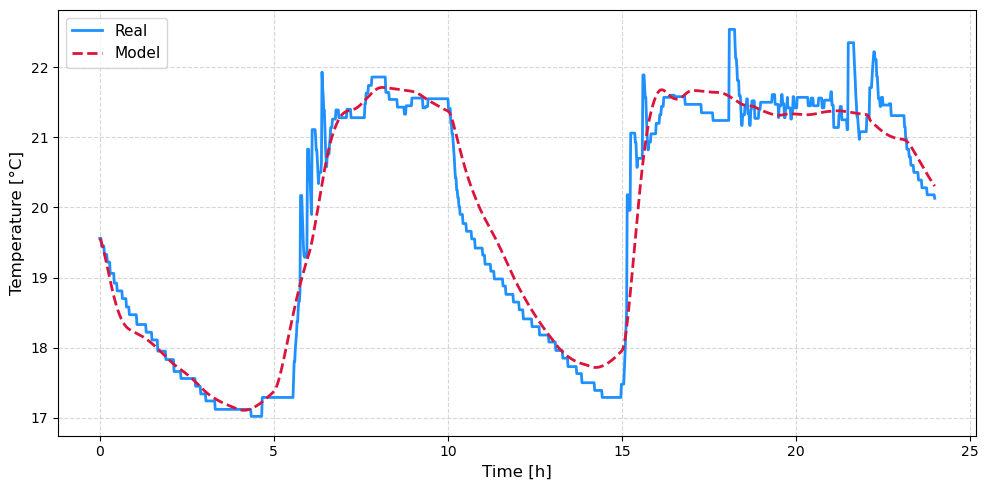

In [7]:
plt.figure(figsize=(10, 5))

plt.plot(__ts[0][0], ys_plot[:, 0], color="dodgerblue", label="Real", linewidth=2)

plt.plot(__ts[0][0], model_y_plot[:, 0], color="crimson", label="Model", linestyle="--", linewidth=2)

plt.xlabel("Time [h]", fontsize=12)
plt.ylabel("Temperature [°C]", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=11)

plt.tight_layout()

plt.show()
